# Импорт библиотек

In [ ]:
!pip install tfrecord

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import tfrecord
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
import torchvision.transforms as transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Загрузка датасета

In [ ]:
DATASET_PATH = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224"

def transform_tf_to_df(subset_data):
    df = pd.DataFrame({"id": pd.Series(dtype="str"),
                       "class": pd.Series(dtype="int"),
                       "img": pd.Series(dtype="object")})
    tf_files = []

    for subdir, dirs, files in os.walk(DATASET_PATH):
        if subdir.split("/")[-1] == subset_data:
            for file in files:
                filepath = subdir + os.sep + file
                tf_files.append(filepath)

    for tf_file in tf_files:
        if subset_data == "test":
            loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte", "image": "byte"})
        else:
            loader = tfrecord.tfrecord_loader(tf_file, None, {"id": "byte","image": "byte", "class": "int"})

        for record in loader:
            id_label = record["id"].decode('utf-8')
            label = record["class"][0].item() if subset_data != "test" else None
            img_bytes = np.frombuffer(record["image"], dtype=np.uint8)
            img = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            df.loc[len(df.index)] = [id_label, label, img]
    return df

In [ ]:
df_validation = transform_tf_to_df('val')
df_train = transform_tf_to_df('train')
df_test = transform_tf_to_df('test')

In [ ]:
CLASSES_NUM = len(FLOWER_NAMES)
CLASSES_NUM

104

id       object
class     int64
img      object
dtype: object (12753, 3)


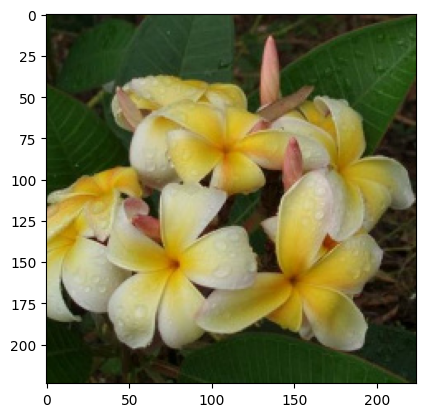

In [ ]:
print(df_train.dtypes, df_train.shape)
plt.imshow(df_train.iloc[2]['img'])

# DataLoader

In [ ]:
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=[0.5, 1.5], contrast=[0.8, 1.2], saturation=[0.8, 1.2]),
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomCrop(200),
    transforms.RandomHorizontalFlip(),
])

test_transforms = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class FlowersDataset(Dataset):
    def __init__(self, data, transform=None) -> None:
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        "Iterable function which applies to each row"
        img_id = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = self.data.iloc[idx, 2]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        y = np.zeros(CLASSES_NUM, dtype=np.float32)
        y[label] = int(1)
        return img_id, y, image

    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.data)

In [ ]:
train_data = FlowersDataset(df_train, transform=train_transforms)
validation_data = FlowersDataset(df_validation, transform=test_transforms)
test_data = FlowersDataset(df_test, transform=test_transforms)

In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          num_workers=2)

validation_loader = DataLoader(dataset=validation_data,
                               batch_size=BATCH_SIZE,
                               num_workers=1)

test_loader = DataLoader(dataset=test_data,
                         batch_size=BATCH_SIZE,
                         num_workers=1,
                         shuffle=False)

# Функции обучения и валидации

In [ ]:
training_loss_count, validation_loss_count  = [], []

def accuracy_step(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_step,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    model.to(device)

    for img_ids, y, X in data_loader:
        X, y = X.to(device), y.to(device)
        #forward
        y_pred = model(X)
        #calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_step(y_true=y.argmax(dim=1), y_pred=y_pred.argmax(dim=1))
        #zerograd
        optimizer.zero_grad()
        #backward
        loss.backward()
        #optimizer
        optimizer.step()
    train_loss /= len(data_loader)
    training_loss_count.append(train_loss.cpu().item())
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def validation_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_step,
              device: torch.device = device):
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for img_ids, y, X in data_loader:
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)
            valid_loss += loss_fn(valid_pred, y)
            valid_acc += accuracy_step(y_true=y.argmax(dim=1), y_pred=valid_pred.argmax(dim=1))
        valid_loss /= len(data_loader)
        validation_loss_count.append(valid_loss.cpu().item())
        valid_acc /= len(data_loader)
        print(f"Validation loss: {valid_loss:.5f} | Validation accuracy: {valid_acc:.2f}%\n")

# Модель и обучение

In [ ]:
model_mobilenet = torchvision.models.mobilenet_v3_large(weights=weights)

# Изменим голову-классификатор модели
model_mobilenet.classifier[3] = torch.nn.Linear(in_features=1280,
                                                out_features=CLASSES_NUM,
                                                bias=True)

# Перенесем модель на нужный девайс
model_mobilenet = model_mobilenet.to(device)

In [ ]:
# Разморозим все слои
for param in model_mobilenet.parameters():
    param.requires_grad = True

In [ ]:
EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenet.parameters(), lr=1e-5)

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model_mobilenet,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_step=accuracy_step,
        device=device)

    validation_step(data_loader=validation_loader,
        model=model_mobilenet,
        loss_fn=loss_fn,
        accuracy_step=accuracy_step,
        device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 3.95445 | Train accuracy: 17.06%


  3%|▎         | 1/30 [00:48<23:34, 48.77s/it]

Validation loss: 3.17680 | Validation accuracy: 31.44%

Epoch: 1
---------
Train loss: 1.91515 | Train accuracy: 54.88%


  7%|▋         | 2/30 [01:36<22:21, 47.89s/it]

Validation loss: 1.20767 | Validation accuracy: 69.29%

Epoch: 2
---------
Train loss: 0.94603 | Train accuracy: 75.13%


 10%|█         | 3/30 [02:23<21:32, 47.87s/it]

Validation loss: 0.88696 | Validation accuracy: 77.42%

Epoch: 3
---------
Train loss: 0.67807 | Train accuracy: 81.78%


 13%|█▎        | 4/30 [03:11<20:39, 47.66s/it]

Validation loss: 0.77255 | Validation accuracy: 79.96%

Epoch: 4
---------
Train loss: 0.53354 | Train accuracy: 85.49%


 17%|█▋        | 5/30 [03:58<19:48, 47.54s/it]

Validation loss: 0.71233 | Validation accuracy: 82.06%

Epoch: 5
---------
Train loss: 0.43491 | Train accuracy: 88.11%


 20%|██        | 6/30 [04:45<18:55, 47.31s/it]

Validation loss: 0.67895 | Validation accuracy: 82.87%

Epoch: 6
---------
Train loss: 0.35892 | Train accuracy: 89.98%


 23%|██▎       | 7/30 [05:32<18:05, 47.20s/it]

Validation loss: 0.66279 | Validation accuracy: 83.22%

Epoch: 7
---------
Train loss: 0.29964 | Train accuracy: 91.73%


 27%|██▋       | 8/30 [06:19<17:15, 47.08s/it]

Validation loss: 0.65257 | Validation accuracy: 83.92%

Epoch: 8
---------
Train loss: 0.24820 | Train accuracy: 92.98%


 30%|███       | 9/30 [07:06<16:30, 47.15s/it]

Validation loss: 0.65382 | Validation accuracy: 83.94%

Epoch: 9
---------
Train loss: 0.21009 | Train accuracy: 94.04%


 33%|███▎      | 10/30 [07:53<15:39, 46.96s/it]

Validation loss: 0.67279 | Validation accuracy: 84.19%

Epoch: 10
---------
Train loss: 0.17409 | Train accuracy: 95.00%


 37%|███▋      | 11/30 [08:39<14:50, 46.89s/it]

Validation loss: 0.66523 | Validation accuracy: 84.78%

Epoch: 11
---------
Train loss: 0.14778 | Train accuracy: 95.86%


 40%|████      | 12/30 [09:26<14:03, 46.84s/it]

Validation loss: 0.67285 | Validation accuracy: 84.86%

Epoch: 12
---------
Train loss: 0.12228 | Train accuracy: 96.73%


 43%|████▎     | 13/30 [10:13<13:17, 46.94s/it]

Validation loss: 0.66188 | Validation accuracy: 85.59%

Epoch: 13
---------
Train loss: 0.10400 | Train accuracy: 96.93%


 47%|████▋     | 14/30 [11:00<12:29, 46.85s/it]

Validation loss: 0.72572 | Validation accuracy: 84.67%

Epoch: 14
---------
Train loss: 0.08615 | Train accuracy: 97.50%


 50%|█████     | 15/30 [11:47<11:42, 46.85s/it]

Validation loss: 0.76607 | Validation accuracy: 83.89%

Epoch: 15
---------
Train loss: 0.07559 | Train accuracy: 97.90%


 53%|█████▎    | 16/30 [12:34<10:55, 46.85s/it]

Validation loss: 0.70461 | Validation accuracy: 85.61%

Epoch: 16
---------
Train loss: 0.06803 | Train accuracy: 98.14%


 57%|█████▋    | 17/30 [13:20<10:08, 46.77s/it]

Validation loss: 0.74683 | Validation accuracy: 84.83%

Epoch: 17
---------
Train loss: 0.05949 | Train accuracy: 98.24%


 60%|██████    | 18/30 [14:07<09:20, 46.70s/it]

Validation loss: 0.77834 | Validation accuracy: 84.62%

Epoch: 18
---------
Train loss: 0.04751 | Train accuracy: 98.65%


 63%|██████▎   | 19/30 [14:54<08:35, 46.82s/it]

Validation loss: 0.77716 | Validation accuracy: 85.13%

Epoch: 19
---------
Train loss: 0.04470 | Train accuracy: 98.75%


 67%|██████▋   | 20/30 [15:40<07:46, 46.67s/it]

Validation loss: 0.75848 | Validation accuracy: 85.40%

Epoch: 20
---------
Train loss: 0.04086 | Train accuracy: 98.82%


 70%|███████   | 21/30 [16:27<07:00, 46.77s/it]

Validation loss: 0.76446 | Validation accuracy: 85.88%

Epoch: 21
---------
Train loss: 0.03353 | Train accuracy: 99.03%


 73%|███████▎  | 22/30 [17:14<06:13, 46.74s/it]

Validation loss: 0.80369 | Validation accuracy: 86.37%

Epoch: 22
---------
Train loss: 0.03599 | Train accuracy: 99.00%


 77%|███████▋  | 23/30 [18:01<05:27, 46.82s/it]

Validation loss: 0.77706 | Validation accuracy: 86.02%

Epoch: 23
---------
Train loss: 0.03199 | Train accuracy: 99.14%


 80%|████████  | 24/30 [18:48<04:40, 46.81s/it]

Validation loss: 0.81866 | Validation accuracy: 85.86%

Epoch: 24
---------
Train loss: 0.03317 | Train accuracy: 98.99%


 83%|████████▎ | 25/30 [19:34<03:53, 46.80s/it]

Validation loss: 0.79974 | Validation accuracy: 85.78%

Epoch: 25
---------
Train loss: 0.03899 | Train accuracy: 99.02%


 87%|████████▋ | 26/30 [20:21<03:06, 46.68s/it]

Validation loss: 0.74776 | Validation accuracy: 86.26%

Epoch: 26
---------
Train loss: 0.02834 | Train accuracy: 99.19%


 90%|█████████ | 27/30 [21:07<02:20, 46.69s/it]

Validation loss: 0.78650 | Validation accuracy: 86.07%

Epoch: 27
---------
Train loss: 0.01982 | Train accuracy: 99.33%


 93%|█████████▎| 28/30 [21:54<01:33, 46.59s/it]

Validation loss: 0.79923 | Validation accuracy: 85.91%

Epoch: 28
---------
Train loss: 0.02585 | Train accuracy: 99.18%


 97%|█████████▋| 29/30 [22:41<00:46, 46.72s/it]

Validation loss: 0.83519 | Validation accuracy: 86.13%

Epoch: 29
---------
Train loss: 0.02303 | Train accuracy: 99.26%


100%|██████████| 30/30 [23:28<00:00, 46.94s/it]

Validation loss: 0.76485 | Validation accuracy: 86.42%



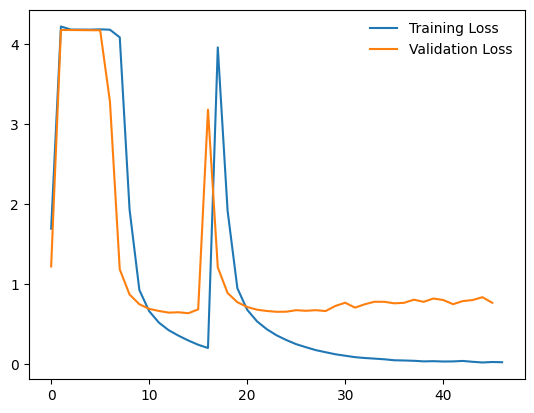

In [ ]:
plt.plot(training_loss_count, label='Training Loss')
plt.plot(validation_loss_count, label='Validation Loss')
plt.legend(frameon=False)

In [ ]:
torch.save(model_mobilenet, 'mobilenet_v1.pt')

# FAISS
Статья на habr - https://habr.com/ru/companies/avito/articles/488658/ <br>
quick start FAISS - https://github.com/facebookresearch/faiss/wiki/Getting-started <br>
Статья как пользовать FAISS на habr - https://habr.com/ru/companies/okkamgroup/articles/509204/ <br><br>
Нужно не только создавать индексы, но еще и хранить их на диске, чтобы при запуске нового инстанса быстро загружать датасет с индексами в оперативную память с диска.

In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 58.0 MB/s eta 0:00:0000:0100:01


In [ ]:
import faiss

In [ ]:
import numpy as np
dim = 512  # рассмотрим произвольные векторы размерности 512
nb = 10000  # количество векторов в индексе
nq = 5 # количество векторов в выборке для поиска
np.random.seed(228)
vectors = np.random.random((nb, dim)).astype('float32')
query = np.random.random((nq, dim)).astype('float32')

In [ ]:
query.shape

(5, 512)

In [ ]:
import faiss
index = faiss.IndexFlatL2(dim)
print(index.ntotal)  # пока индекс пустой
index.add(vectors)
print(index.ntotal)  # теперь в нем 10 000 векторов

0
10000


In [ ]:
topn = 7
D, I = index.search(vectors[:5], topn)  # Возвращает результат: Distances, Indices
print(I)
print(D)

[[   0 5662 6778 7738 6931 7809 7184]
 [   1 5831 8039 2150 5426 4569 6325]
 [   2 7348 2476 2048 5091 6322 3617]
 [   3  791 3173 6323 8374 7273 5842]
 [   4 6236 7548  746 6144 3906 5455]]
[[ 0.       71.53578  72.18823  72.74326  73.2243   73.333244 73.73316 ]
 [ 0.       67.604805 68.49477  68.84222  71.83991  72.084335 72.10817 ]
 [ 0.       66.71786  67.7271   69.63666  70.35903  70.933304 71.03237 ]
 [ 0.       68.26415  68.320595 68.82381  68.86327  69.12088  69.551796]
 [ 0.       72.03398  72.32417  73.00308  73.13054  73.76181  73.81281 ]]


## Создадим вектора всех изображений

In [ ]:
model_mobilenet = torch.load('/kaggle/input/similar-flowers/mobilenet_v1.pt', map_location=device)
model_mobilenet.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=104, bias=True)
)

In [ ]:
# Оставим только hidden layer для получения эмбеддингов
model_mobilenet.classifier = nn.Sequential((model_mobilenet.classifier[0]))
model_mobilenet.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
)

In [ ]:
df_all = pd.concat((df_train, df_validation, df_test)).reset_index(drop=True)
df_all.id

0        3fc7ecd2e
1        ce50aea06
2        80a490799
3        d45ba5294
4        648f4510b
           ...    
23842    2a608c0db
23843    d82a21bbd
23844    f9c931893
23845    18c7b92b8
23846    523df966b
Name: id, Length: 23847, dtype: object

In [ ]:
len(df_all.id.unique())

23847

In [ ]:
all_data = FlowersDataset(df_all[:5000], transform=test_transforms)
all_data_loader = DataLoader(dataset=all_data,
                         batch_size=BATCH_SIZE,
                         num_workers=1,
                         shuffle=False)

In [ ]:
def get_vectors(model, data_loader):
    vectors = None
    with torch.inference_mode():
        for img_ids, y, X in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)

            if vectors is None:
                vectors = valid_pred.cpu().numpy()
            else:
                vectors = np.vstack((vectors, valid_pred.cpu().numpy()))
    return vectors

all_vectors = get_vectors(model_mobilenet, all_data_loader)

100%|██████████| 313/313 [00:13<00:00, 23.72it/s]


In [ ]:
len(df_all), all_vectors.shape

(23847, (5000, 1280))

## Загрузим полученные векторы в FAISS

In [ ]:
# Зададим размерность вектора, равную длине эмбеддинга
dim = all_vectors.shape[1]

index = faiss.IndexFlatL2(dim)
print(index.ntotal)  # пока индекс пустой
index.add(all_vectors)
print(index.ntotal)  # теперь в нем 10 000 векторов

0
5000


In [ ]:
topn = 7
D, I = index.search(all_vectors[101:102], topn)  # Возвращает результат: Distances, Indices
print(I)
print(D)

[[ 101 3273 2223 2795 2067 3978  450]]
[[     0.   146047.16 149005.48 153303.16 162817.38 167073.6  171546.17]]


## Тесты

53


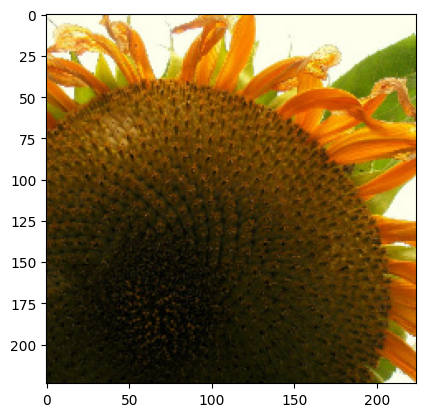

In [ ]:
plt.imshow(df_all.loc[101, 'img'])
print(df_all.loc[101, 'class'])

53


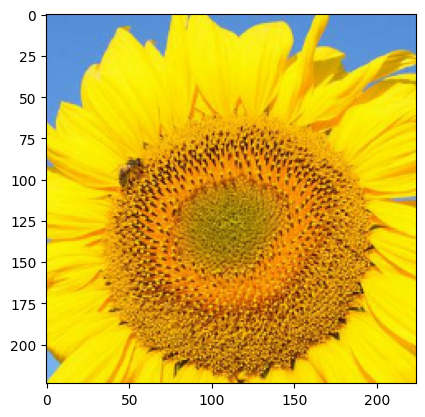

In [ ]:
num_id = 3273
plt.imshow(df_all.loc[num_id, 'img'])
print(df_all.loc[num_id, 'class'])

## Сохраним фотки

In [ ]:
DIR_DATASET = 'all_flowers'
if not os.path.exists(DIR_DATASET):
    os.mkdir(DIR_DATASET)

for i, row in tqdm(df_all[:2000].iterrows(), total=len(df_all[:2000])):
    img_id = row['id']
    img = row['img']
    img_path = os.path.join(DIR_DATASET, img_id+'.jpg')
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

100%|██████████| 2000/2000 [00:03<00:00, 631.45it/s]


In [ ]:
!zip all_flowers.zip all_flowers -r

  adding: all_flowers/ (stored 0%)
  adding: all_flowers/211f1e6b0.jpg (deflated 1%)
  adding: all_flowers/81575b5d7.jpg (deflated 1%)
  adding: all_flowers/890cde075.jpg (deflated 1%)
  adding: all_flowers/8e0b02b8d.jpg (deflated 1%)
  adding: all_flowers/9f8958af5.jpg (deflated 1%)
  adding: all_flowers/6e17561b2.jpg (deflated 1%)
  adding: all_flowers/e66502b1b.jpg (deflated 1%)
  adding: all_flowers/0996d75ae.jpg (deflated 1%)
  adding: all_flowers/f12782678.jpg (deflated 1%)
  adding: all_flowers/b9c5fa02d.jpg (deflated 1%)
  adding: all_flowers/44d96d769.jpg (deflated 1%)
  adding: all_flowers/e75c5e335.jpg (deflated 1%)
  adding: all_flowers/eff5c5b9b.jpg (deflated 1%)
  adding: all_flowers/afe0732fa.jpg (deflated 1%)
  adding: all_flowers/2e357021a.jpg (deflated 1%)
  adding: all_flowers/99c9607c5.jpg (deflated 1%)
  adding: all_flowers/2aa8cf8ac.jpg (deflated 1%)
  adding: all_flowers/11b29f5fb.jpg (deflated 1%)
  adding: all_flowers/bbe3157c2.jpg (deflated 1%)
  adding: all_f

In [ ]:
!rm all_flowers -r

In [ ]:
!rm all_flowers.zip

In [ ]:
df_all[['id', 'class']][:2000].to_csv('all_flowers_2k.csv', index=False)

## Сохраним FAISS для 2к фоток

In [ ]:
faiss.write_index(index, "all_flowers_2k.index")

In [ ]:
index = faiss.read_index("all_flowers_2k.index")

In [ ]:
topn = 7
D, I = index.search(all_vectors[101:102], topn)  # Возвращает результат: Distances, Indices
print(I)
print(D)

[[ 101 3273 2223 2795 2067 3978  450]]
[[     0.   146047.16 149005.48 153303.16 162817.38 167073.6  171546.17]]


In [ ]:
# Очистим kaggle output
!rm all_flowers.csv
!rm all_flowers_2k.csv
!rm all_flowers_2k.index

**Все работает**

# План дипломной работы
## Модель
1. Обучить модель классификации
2. На эмбеддингах (предпоследнем слое) модели вызывать с помощью FAISS n ближайших катинок и отображать их на веб-морде. В веб-морде также можно будет и прогружать следующие n похожих фото

## Веб-морда
1. В веб-морду можно загрузить картинку или вставить на нее ссылку или загрузить рандомную из имеющегося датасета и нажать на кнопку "Загрузить похожие картинки"
2. В веб-морде можно указать ip сервера, к которому можно сейчас обращаться для получения результатов. Этим ip может быть мой ПК, на котором запущен сервер, и ip прокинут через firewall от cloudflare.